In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

dataset = datasets.MNIST('../data', train=True, download=True)

#make subset
num_samples = len(dataset) #// 5
indices = random.sample(range(len(dataset)), num_samples)

# convert to data, labels
data = dataset.data[indices]
labels = dataset.targets[indices]
data.shape, labels.shape



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 557kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]


(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
class MNIST(torch.utils.data.Dataset):
    def __init__(self, dataset, subset=None, labels=None):
        super(MNIST, self).__init__()
        self.data = dataset[subset] if subset is not None else dataset
        if labels is not None:
            self.labels = labels[subset] if subset is not None else labels

        self.data = self.data.view(-1, 1, 28, 28).double() / 255.0
        self.data = (self.data > 0.5).double()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index]

In [6]:
# get the same split every time
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

set_all_seeds(0)

# Split data into train, validation and test sets (82/9/9)
indices = np.arange(len(data))
np.random.shuffle(indices)
print(indices.shape)

train_size = int(0.82 * len(indices))
val_size = int(0.09 * len(indices))
test_size = len(indices) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_data = MNIST(data, train_indices, labels)
val_data = MNIST(data, val_indices, labels)
test_data = MNIST(data, test_indices, labels)

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data.data.shape, val_data.data.shape, test_data.data.shape


(60000,)


(torch.Size([49200, 1, 28, 28]),
 torch.Size([5400, 1, 28, 28]),
 torch.Size([5400, 1, 28, 28]))

In [7]:
#print(type(data))  # 可能是 <class 'numpy.ndarray'> 或 <class 'torch.Tensor'>
#print(type(train_data))  # 可能不是 NumPy 数组或 Tensor
#print(type(train_data[1]))  # 检查单个样本的类型


In [8]:
# visualize data
#plt.imshow(train_data.data[0].view(28, 28).numpy(), cmap='gray')
#plt.show()

### DGD

In [29]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 7 * 7 * 64),
            nn.SiLU(),
            nn.Unflatten(1, (64, 7, 7)),  # reshape to 64x7x7
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # -> 1x28x28
            #nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)

    def init_samples(self, n_samples):
        return nn.Parameter(torch.randn(n_samples, self.latent_dim, device=device) * 0.001)


In [30]:
device = torch.device('cuda')

model = ConvDecoder(latent_dim=32).to(device)
model.z = model.init_samples(len(train_data))        # [N_train, latent_dim]
model.z_val = model.init_samples(len(val_data))      # [N_val, latent_dim]
model.z_test = model.init_samples(len(test_data))    # [N_test, latent_dim]
print("z shape:", model.z.shape, "\nz_val shape:", model.z_val.shape, "\nz_test shape:", model.z_test.shape)

model

z shape: torch.Size([49200, 32]) 
z_val shape: torch.Size([5400, 32]) 
z_test shape: torch.Size([5400, 32])


ConvDecoder(
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3136, bias=True)
    (3): SiLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [31]:
# find fraction
def sample_features(fraction, input):
    x = int(input*fraction)
    idx = torch.randperm(input)[:x]
    return idx

### Next up: define the training loop to train the model using the train and validation loaders

Starting training...
Epoch [1/500], Train Loss: 0.2960
Validation Loss: 0.2627
Epoch [2/500], Train Loss: 0.2639
Validation Loss: 0.2614
Epoch [3/500], Train Loss: 0.2639
Validation Loss: 0.2624
Early stopping counter: 1/10
Epoch [4/500], Train Loss: 0.2632
Validation Loss: 0.2621
Early stopping counter: 2/10
Epoch [5/500], Train Loss: 0.2630
Validation Loss: 0.2635
Early stopping counter: 3/10
Epoch [6/500], Train Loss: 0.2634
Validation Loss: 0.2624
Early stopping counter: 4/10
Epoch [7/500], Train Loss: 0.2638
Validation Loss: 0.2611
Epoch [8/500], Train Loss: 0.2638
Validation Loss: 0.2628
Early stopping counter: 1/10
Epoch [9/500], Train Loss: 0.2635
Validation Loss: 0.2629
Early stopping counter: 2/10
Epoch [10/500], Train Loss: 0.2633
Validation Loss: 0.2654
Early stopping counter: 3/10
Epoch [11/500], Train Loss: 0.2636
Validation Loss: 0.2642
Early stopping counter: 4/10
Epoch [12/500], Train Loss: 0.2640
Validation Loss: 0.2631
Early stopping counter: 5/10
Epoch [13/500], Tra

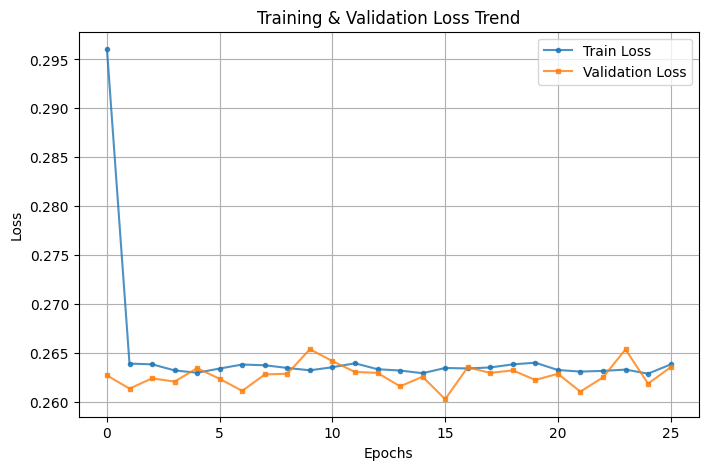

In [32]:
def train_decoder(
    model, train_loader, val_loader,
    model_optimizer, rep_optimizer, val_rep_optimizer,
    num_epochs=300, patience=10, device='cuda'
):
    criterion = nn.BCEWithLogitsLoss()
    print("Starting training...")

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        for indices, inputs in train_loader:
            rep_optimizer.zero_grad()
            model_optimizer.zero_grad()
            indices, inputs = indices.to(device), inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)

            # Forward pass through decoder
            z_batch = model.z[indices]
            outputs = model(z_batch)
            outputs = outputs.view(outputs.size(0), -1)

            #print(outputs.shape, inputs.shape)
            fraction = 0.6
            feature_idx = sample_features(fraction, inputs.shape[-1])
            feature_idx = feature_idx.to(device)
            loss = criterion(outputs[:,feature_idx], inputs[:,feature_idx])
            #print(loss)

            # Backward pass for decoder parameters
            loss.backward()  # Retain the graph for `z`
            model_optimizer.step()
            train_loss += loss.item()
            rep_optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0

        for indices, inputs in val_loader:
            indices, inputs = indices.to(device), inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)

            val_rep_optimizer.zero_grad()
            # Forward pass through decoder
            z_batch = model.z_val[indices]
            outputs = model(z_batch)
            outputs = outputs.view(outputs.size(0), -1)
            fraction = 0.6
            feature_idx = sample_features(fraction, inputs.shape[-1])
            loss = criterion(outputs[:,feature_idx], inputs[:,feature_idx])
            loss.backward()
            val_loss += loss.item()
            val_rep_optimizer.step()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            print(f"Early stopping counter: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break  # Stop training

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=3, alpha=0.8, linewidth=1.5)
    plt.plot(val_losses, label='Validation Loss', marker='s', markersize=3, alpha=0.8, linewidth=1.5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Trend")
    plt.legend()
    plt.grid()
    plt.show()

model_optimizer = optim.Adam(model.decoder.parameters(), lr=0.001, weight_decay=1e-4, betas=(0.5, 0.7))
rep_optimizer = optim.Adam([model.z], lr=0.1, weight_decay=1e-4, betas=(0.5, 0.7))
val_rep_optimizer = optim.Adam([model.z_val], lr=0.1, weight_decay=1e-4, betas=(0.5, 0.7))

train_decoder(model, train_loader, val_loader, model_optimizer, rep_optimizer,val_rep_optimizer, num_epochs=500, patience=10, device=device)


## Plot

### latent rep

In [33]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

z = model.z.detach().numpy()
z_val = model.z_val.detach().numpy()
z_test = model.z_test.detach().numpy()
z_all = np.vstack([z, z_val, z_test])

y_train = train_data.labels
y_val = val_data.labels
y_test = test_data.labels
y2 = np.concatenate([y_train, y_val, y_test])

num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
pred_labels = kmeans.fit_predict(z_all)

# 计算 Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(y2, pred_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# 计算混淆矩阵
conf_mat = confusion_matrix(y2, pred_labels)

#row_ind, col_ind = linear_sum_assignment(-conf_mat)  # 负号表示最大化匹配
#mapping = {col: row for row, col in zip(row_ind, col_ind)}

# 重新映射 KMeans 预测标签
#pred_labels_mapped = np.array([mapping[label] for label in pred_labels])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sc1 = ax[0].scatter(z_all[:, 0], z_all[:, 1], c=y2, cmap='tab10', alpha=0.5, s=3)
ax[0].set_title("True Labels")
ax[0].set_xlabel("Dimension 1")
ax[0].set_ylabel("Dimension 2")
plt.colorbar(sc1, ax=ax[0], label="True Cluster ID")

sc2 = ax[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_labels, cmap='tab10', alpha=0.5, s=3)
ax[1].set_title("KMeans Predicted Labels (Aligned)")
ax[1].set_xlabel("Dimension 1")
ax[1].set_ylabel("Dimension 2")
plt.colorbar(sc2, ax=ax[1], label="Aligned Predicted Cluster ID")

plt.tight_layout()
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
print(y2[:20])
print(pred_labels[:20])

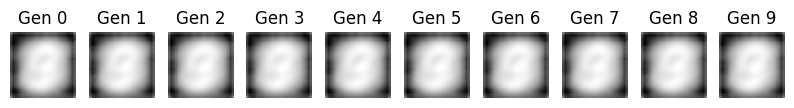

In [35]:
import matplotlib.pyplot as plt

z_all = torch.cat([model.z, model.z_val, model.z_test], dim=0)  # 保持 PyTorch Tensor
z_decoded = model.decoder(z_all).cpu()

fig, axes = plt.subplots(1, 10, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(z_decoded[i].view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f"Gen {i}")
    ax.axis('off')
plt.show()

## Test

In [36]:
def test_decoder(model, test_loader, test_rep_optimizer, num_epochs=10, device='cuda'):
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    patience = 5
    best_test_loss = float('inf')
    epochs_without_improvement = 0

    print("Optimizing z_test...")

    for epoch in range(num_epochs):
        test_loss = 0


        for indices, inputs in test_loader:
            indices, inputs = indices.to(device), inputs.to(device)
            test_rep_optimizer.zero_grad()
            z_batch = model.z_test[indices]
            outputs = model(z_batch)

            loss = criterion(outputs, inputs)
            loss.backward()
            test_loss += loss.item()

            test_rep_optimizer.step()

        test_loss /= len(test_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            print(f"Early stopping counter: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

    print("Optimization of z_test complete.")
    return test_loss

test_rep_optimizer = optim.Adam([model.z_test], lr=0.1, weight_decay=1e-4, betas=(0.5, 0.7))

test_loss = test_decoder(model, test_loader, test_rep_optimizer, num_epochs=200, device=device)

Optimizing z_test...
Epoch [1/200], Test Loss: 0.2622
Epoch [2/200], Test Loss: 0.2622
Epoch [3/200], Test Loss: 0.2622
Epoch [4/200], Test Loss: 0.2622
Early stopping counter: 1/5
Epoch [5/200], Test Loss: 0.2622
Early stopping counter: 2/5
Epoch [6/200], Test Loss: 0.2622
Early stopping counter: 3/5
Epoch [7/200], Test Loss: 0.2622
Early stopping counter: 4/5
Epoch [8/200], Test Loss: 0.2622
Early stopping counter: 5/5
Early stopping triggered
Optimization of z_test complete.


## benchmark

In [37]:
z = model.z.detach().cpu().numpy()
z_val = model.z_val.detach().cpu().numpy()
z_test = model.z_test.detach().cpu().numpy()

X_train_val = np.concatenate([z, z_val], axis=0)
y_train_val = np.concatenate([train_data.labels, val_data.labels], axis=0)

y_train_val = y_train_val.astype(int)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_val, y_train_val)

y_pred = clf.predict(z_test)

acc = accuracy_score(test_data.labels, y_pred)
print(f"Logistic Regression Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.1146
